In [226]:
import numpy as np
from scipy.linalg import eigh, eig
from scipy.sparse import diags
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt
import time

[[-4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -4.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  1. -4.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0. -4.  1.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0. -4.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4. 

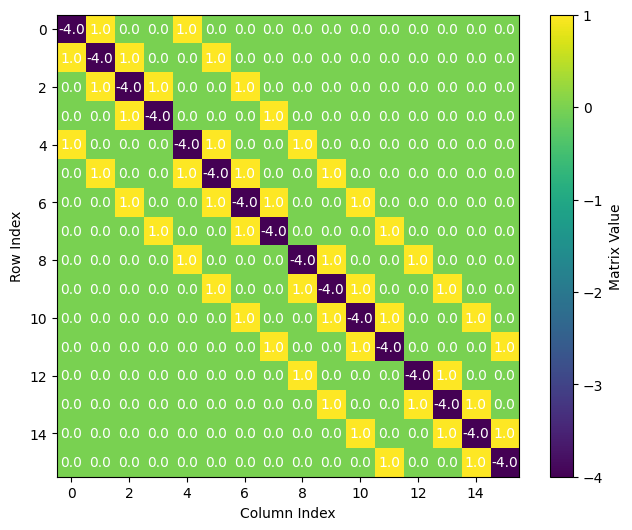

In [223]:
def create_reflective_laplacian(n, m):
    N = n * m  # Total number of points in the grid
    M = np.zeros((N, N))  # Initialize matrix with zeros

    for i in range(N):
        # Default value for cells
        M[i, i] = -4
        
        # Calculate row and column in the grid
        row, col = divmod(i, m)

        # Set connections for adjacent cells, considering the grid layout
        if col != 0:  # Not on the left edge
            M[i, i - 1] = 1  # Left neighbor
        if col != (m - 1):  # Not on the right edge
            M[i, i + 1] = 1  # Right neighbor
        if row != 0:  # Not on the top edge
            M[i, i - m] = 1  # Top neighbor
        if row != (n - 1):  # Not on the bottom edge
            M[i, i + m] = 1  # Bottom neighbor

    return M

# Example usage
n, m = 4, 4 # Change these to create a different size grid
L = create_reflective_laplacian(n, m)
print(L)

# Plot the matrix
plt.figure(figsize=(8, 6))
plt.imshow(L, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Matrix Value')
# plt.title('Reflective Laplacian Matrix')
plt.xlabel('Column Index')
plt.ylabel('Row Index')

# Add annotations for each matrix element
for i in range(L.shape[0]):
    for j in range(L.shape[1]):
        plt.text(j, i, f'{L[i, j]:.1f}', ha='center', va='center', color='white')

plt.show()


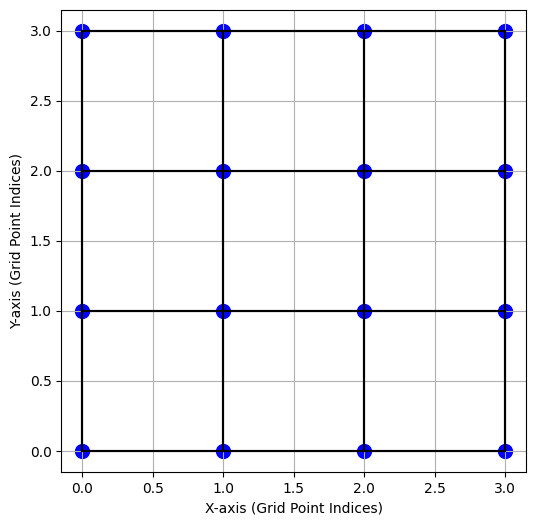

In [224]:
# Generate grid points
x = np.arange(0, m)
y = np.arange(0, n)
X, Y = np.meshgrid(x, y)

# Plot grid points
plt.figure(figsize=(6, 6))
plt.scatter(X, Y, color='blue', s=100)

# Plot connections between grid points
for i in range(n):
    for j in range(m):
        index = i * m + j
        if j > 0:  # Not on the left edge
            plt.plot([j - 1, j], [i, i], color='black')  # Left neighbor
        if j < m - 1:  # Not on the right edge
            plt.plot([j + 1, j], [i, i], color='black')  # Right neighbor
        if i > 0:  # Not on the top edge
            plt.plot([j, j], [i - 1, i], color='black')  # Top neighbor
        if i < n - 1:  # Not on the bottom edge
            plt.plot([j, j], [i + 1, i], color='black')  # Bottom neighbor

# plt.title('Discretization of Membrane Grid')
plt.xlabel('X-axis (Grid Point Indices)')
plt.ylabel('Y-axis (Grid Point Indices)')
plt.grid(True)
plt.show()

In [57]:
def create_circular_laplacian(n, m, radius):
    # Total points
    N = n * m
    # Center of the circle, adjusted for the rectangular grid
    center = np.array([n / 2 - 0.5, m / 2 - 0.5])
    # Initialize the matrix
    M = np.zeros((N, N))

    # Identify points inside the circle
    inside_circle = []
    for i in range(n):
        for j in range(m):
            if (np.array([i, j]) - center).dot(np.array([i, j]) - center) <= radius**2:
                inside_circle.append(i * m + j)

    # Now build the Laplacian only for these points
    for idx in inside_circle:
        x, y = divmod(idx, m)
        M[idx, idx] = -4
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < n and 0 <= ny < m and nx * m + ny in inside_circle:
                M[idx, nx * m + ny] = 1

    # Filter out the unused rows and columns
    M = M[np.ix_(inside_circle, inside_circle)]

    return M

# Example usage
n, m = 5, 6  # Change these for a different size grid
radius = 2  # Adjust radius as needed
L_circle_corrected = create_circular_laplacian(n, m, radius)

# Check if the matrix is square
if L_circle_corrected.shape[0] == L_circle_corrected.shape[1]:
    print("The matrix is square.")
    try:
        vals_circle, vecs_circle = eigh(L_circle_corrected)
        # Continue with your analysis or plotting
    except ValueError as e:
        print("Error in eigenvalue computation:", e)
else:
    print("The matrix is not square, check the Laplacian construction.")


The matrix is square.


In [58]:
# Square grid (already done)
n, m = 20, 20 
L_square = create_reflective_laplacian(n, m)

# Rectangle grid
n, m = 10, 20  # Change these for a different size grid
L_rect = create_reflective_laplacian(n, m)

# Circular grid
n, m = 5, 6  # Change these for a different size grid
radius = 2  # Make sure L and n are defined
L_circle = create_circular_laplacian(n, m, radius)

In [59]:
def solve_eigenproblem(L_square):
    # Solve the eigenvalue problem
    eigenvalues, eigenvectors = eigh(L_square)

    # Convert eigenvalues to real numbers
    eigenvalues = np.real(eigenvalues)

    # Create the dictionary mapping eigenvalues to eigenvectors
    eigen_dict = {}
    for i, val in enumerate(eigenvalues):
        vec = eigenvectors[:, i]
        # Convert complex eigenvectors to real and make them lists for easy representation
        vec_list = np.real(np.abs(vec)).tolist()
        # Add to dictionary
        eigen_dict[val] = vec_list

    return eigen_dict

In [202]:
def plot_eigenvectors(eigen_dict, nrows=None, ncols=None, num_eigenvectors=10, target_eigenvalue=0):
    # Sort eigenvalues based on closeness to the target_eigenvalue, select the closest num_eigenvectors
    sorted_eigenvals = sorted(eigen_dict.keys(), key=lambda x: abs(x - target_eigenvalue))
    closest_eigenvals = sorted_eigenvals[:num_eigenvectors]

    # Set up the plot
    num_rows = (num_eigenvectors + 4) // 5  # Calculate number of rows for subplots
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    # Plot each of the closest eigenvectors as a heatmap
    for idx, eigenvalue in enumerate(closest_eigenvals):
        row = idx // 5  # Calculate the row index
        col = idx % 5   # Calculate the column index
        eigenvector = eigen_dict[eigenvalue]
        # Reshape eigenvector to a rectangle or square array
        if nrows is not None and ncols is not None:
            matrix = np.reshape(eigenvector, (nrows, ncols))
        else:
            # Fallback to square shape if dimensions are not specified
            side_length = int(np.sqrt(len(eigenvector)))
            matrix = np.reshape(eigenvector, (side_length, side_length))
        
        # Plot the heatmap
        c = axes[row, col].imshow(matrix, cmap='viridis', aspect='auto')
        axes[row, col].set_title(f'Eigenvalue: {eigenvalue:.2e}', fontsize=14)  # Using scientific notation for clarity
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])

    # Add color bar
    # fig.colorbar(c, ax=axes.ravel().tolist(), orientation='vertical')

    cbar_ax = fig.add_axes([1, 0.025, 0.02, 0.91])  # [left, bottom, width, height]
    cbar = fig.colorbar(c, cax=cbar_ax)
    cbar.set_label('Frequency', fontsize=14)

    plt.tight_layout()
    plt.show()

391


C:\Users\sacha\AppData\Local\Temp\ipykernel_15980\3768001053.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


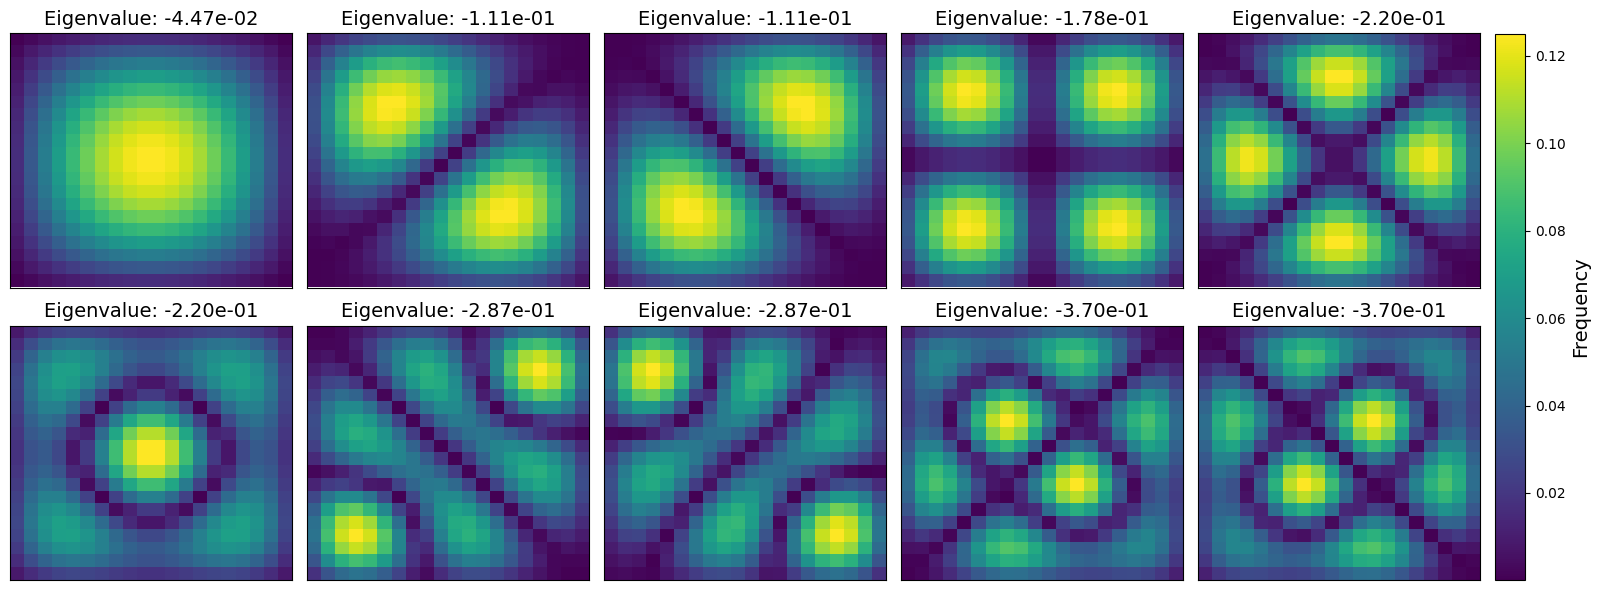

In [227]:
eigen_dict = solve_eigenproblem(L_square)
print(len(eigen_dict))
plot_eigenvectors(eigen_dict)

C:\Users\sacha\AppData\Local\Temp\ipykernel_15980\3768001053.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


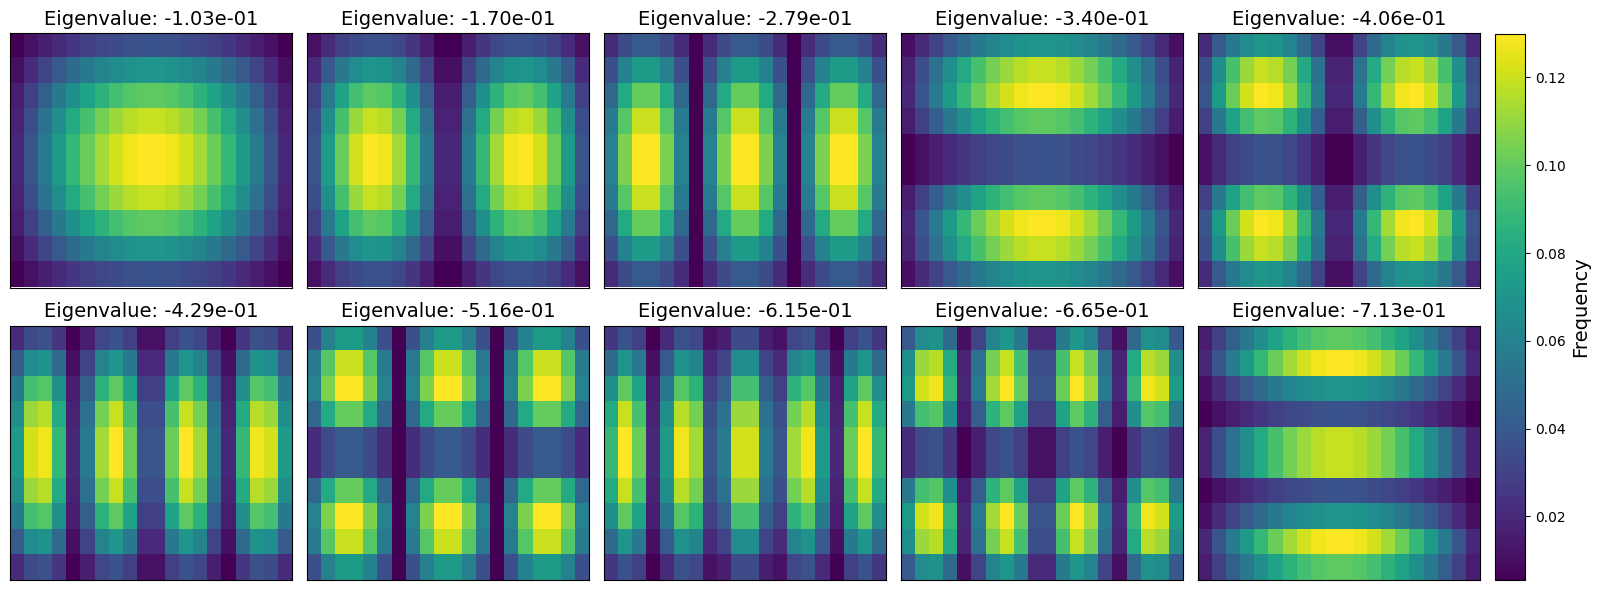

In [228]:
n, m = 10, 20  # Change these for a different size grid
eigen_dict = solve_eigenproblem(L_rect)
plot_eigenvectors(eigen_dict, nrows=n, ncols=m)

In [153]:
def embed_eigenvector_in_grid(eigenvector, n, m, inside_circle):
    """
    Embeds an eigenvector defined on the points inside a circle back into the full n x m grid.

    Parameters:
    eigenvector (numpy.ndarray): The flattened eigenvector defined only for points inside the circle.
    n (int): The number of rows in the full grid.
    m (int): The number of columns in the full grid.
    inside_circle (list): List of indices in the flattened full grid that correspond to points inside the circle.

    Returns:
    numpy.ndarray: The full n x m grid with the eigenvector embedded at the correct locations and zeros elsewhere.
    """
    # Create an empty array for the full grid
    full_grid = np.zeros(n * m)

    # Place the components of the eigenvector into the full grid at the appropriate locations
    for index, value in zip(inside_circle, eigenvector):
        full_grid[index] = value

    # Reshape the full grid back into a 2D array
    full_grid = full_grid.reshape((n, m))

    return full_grid

C:\Users\sacha\AppData\Local\Temp\ipykernel_15980\547616782.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


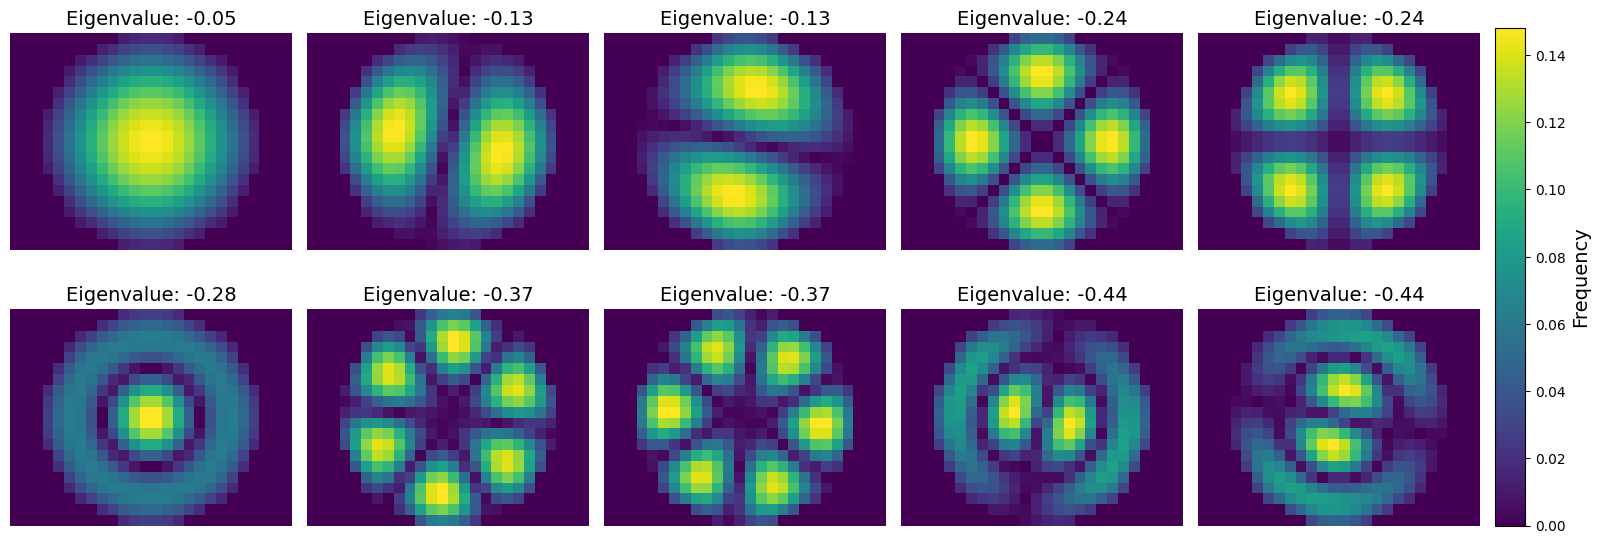

In [201]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

def plot_circular_eigenvectors(vals_circle, vecs_circle, n, m, radius, num_eigenvectors=10):
    # Calculate the positions inside the circle to properly embed eigenvectors later
    center = np.array([n / 2 - 0.5, m / 2 - 0.5])
    inside_circle = [i * m + j for i in range(n) for j in range(m) 
                     if np.linalg.norm(np.array([i, j]) - center) <= radius]

    # Sort eigenvalues and pick the indices of the closest to zero
    indices_closest = np.argsort(np.abs(vals_circle))[:num_eigenvectors]

    # Set up the plot
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    # Plot the specified number of closest eigenvectors
    for i, idx in enumerate(indices_closest):
        row = i // 5  # Calculate the row index
        col = i % 5   # Calculate the column index
        
        # Embed the eigenvector back into the full grid
        full_grid = embed_eigenvector_in_grid(np.abs(vecs_circle[:, idx]), n, m, inside_circle)
        
        # Plot the heatmap
        c = axes[row, col].imshow(full_grid, cmap='viridis', extent=[0, m, 0, n], origin='lower')
        axes[row, col].set_title(f'Eigenvalue: {vals_circle[idx]:.2f}', fontsize=14)
        axes[row, col].axis('off')
    
    cbar_ax = fig.add_axes([1, 0.09, 0.02, 0.83])  # [left, bottom, width, height]
    cbar = fig.colorbar(c, cax=cbar_ax)
    cbar.set_label('Frequency', fontsize=14)

    plt.tight_layout()
    plt.show()

# Usage example
n, m = 20, 26  # Grid size
radius = 10  # Circle radius
L_circle_corrected = create_circular_laplacian(n, m, radius)
vals_circle, vecs_circle = eigh(L_circle_corrected)  # Compute eigenvalues and eigenvectors

plot_circular_eigenvectors(vals_circle, vecs_circle, n, m, radius)  # Adjust num_eigenvectors if needed


In the provided code, eigh() from scipy.linalg was used to solve the eigenvalue problem for the Laplacian matrix representing the reflective boundary conditions. The choice of eigh() over other options like eig() or eigs() was made because eigh() is specifically designed to efficiently solve Hermitian eigenvalue problems for symmetric matrices.

Since the Laplacian matrix representing the reflective boundary conditions is symmetric due to the nature of the problem, using eigh() is appropriate and efficient. This function is optimized for symmetric matrices, leading to faster computation times compared to other methods when dealing with such matrices. Therefore, eigh() was selected for its efficiency and suitability for the given problem.

In [165]:
# Example usage
n, m = 20, 20  # Change these for a different size grid
L = create_reflective_laplacian(n, m)

# Solve the eigenvalue problem using scipy.linalg.eig()
start_time = time.time()
eigenvalues_eig, eigenvectors_eig = eig(L)
end_time = time.time()
eig_time = end_time - start_time

# Solve the eigenvalue problem using scipy.linalg.eigh()
start_time = time.time()
eigenvalues_eigh, eigenvectors_eigh = eigh(L)
end_time = time.time()
eigh_time = end_time - start_time


# Solve the eigenvalue problem using scipy.sparse.linalg.eigs() for sparse matrices
start_time = time.time()
eigenvalues_eigs, eigenvectors_eigs = eigs(L)
end_time = time.time()
eigs_time = end_time - start_time

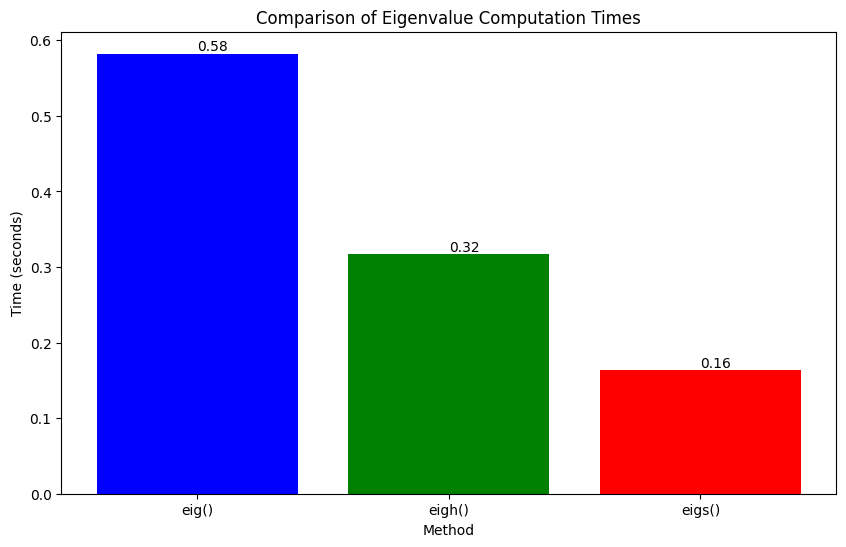

In [166]:
# Computation times from your results
method_names = ['eig()', 'eigh()', 'eigs()']
times = [eig_time, eigh_time, eigs_time]

# Create a bar chart
plt.figure(figsize=[10,6])
bars = plt.bar(method_names, times, color=['blue', 'green', 'red'])

# Add the exact computation time above each bar for clarity
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom')  # Adjust the format as needed

# Set chart title and labels
plt.title('Comparison of Eigenvalue Computation Times')
plt.ylabel('Time (seconds)')
plt.xlabel('Method')

# Show the plot
plt.show()


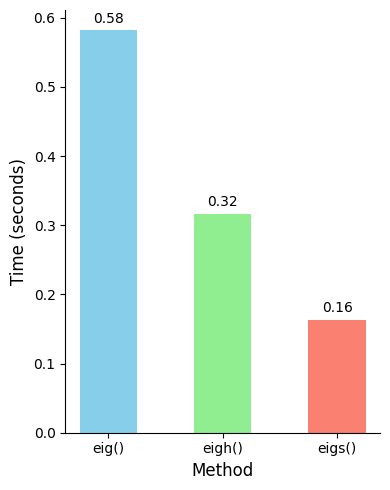

In [175]:
# Define the method names and corresponding computation times
method_names = ['eig()', 'eigh()', 'eigs()']
times = [eig_time, eigh_time, eigs_time]

# Set up the figure and axis
plt.figure(figsize=[4, 5])  # Adjust the figure width
ax = plt.gca()

# Create vertical bars with reduced width
bars = ax.bar(method_names, times, color=['skyblue', 'lightgreen', 'salmon'], width=0.5)  # Adjust the bar width

# Add exact computation time above each bar for clarity
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

# Set chart title and labels
# ax.set_title('Comparison of \n Eigenvalue \n Computation Times', fontsize=14)
ax.set_ylabel('Time (seconds)', fontsize=12)
ax.set_xlabel('Method', fontsize=12)

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


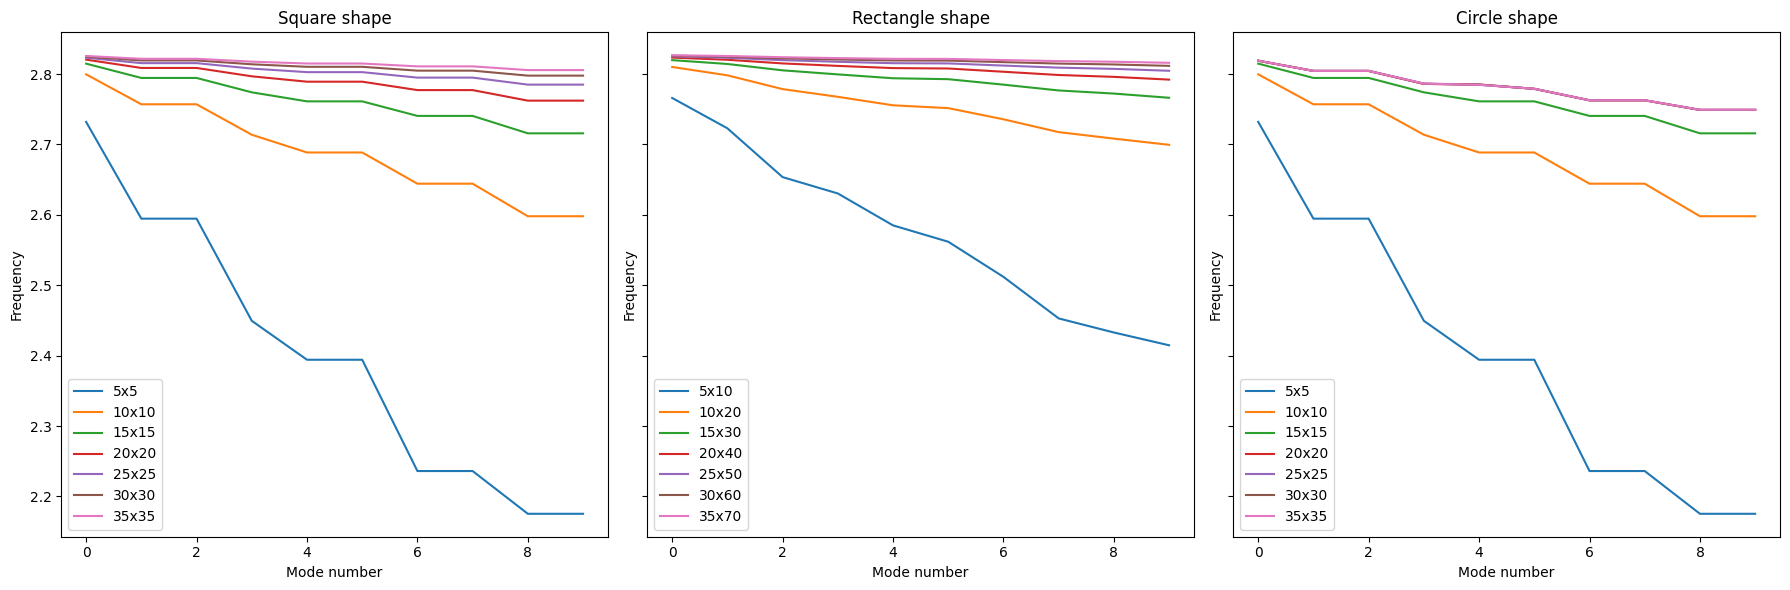

In [204]:
# Function to solve and return eigenvalues
def solve_eigenvalues(L):
    eigenvalues, eigenvec = eigh(L)  # Only need eigenvalues, not eigenvectors\
    return np.sqrt(np.abs(eigenvalues))  # Return the square root of eigenvalues for frequencies

# Define sizes and shapes for the analysis
sizes = range(5, 36, 5)  # From 5x5 to 25x25 with steps of 5
shapes = ['square', 'rectangle', 'circle']
radius = 10  # Fixed radius for circular shape
results = {shape: [] for shape in shapes}

# Calculate eigenfrequencies for each shape and size
for size in sizes:
    for shape in shapes:
        if shape == 'circle':
            L = create_circular_laplacian(size, size, radius=radius)
        else:
            L = create_reflective_laplacian(size, size if shape == 'square' else size * 2)  # Double the size for rectangle
        eigenvalues = solve_eigenvalues(L)
        results[shape].append(eigenvalues[:10])  # Store first 10 eigenfrequencies

# print(results[shape])
# Plotting the results
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for ax, shape in zip(axes, shapes):
    for size, freqs in zip(sizes, results[shape]):
        ax.plot(freqs, label=f'{size}x{size}' if shape != 'rectangle' else f'{size}x{size * 2}')
    ax.set_title(f'{shape.capitalize()} shape')
    ax.set_xlabel('Mode number')
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.show()

ValueError: cannot reshape array of size 4 into shape (5,5)

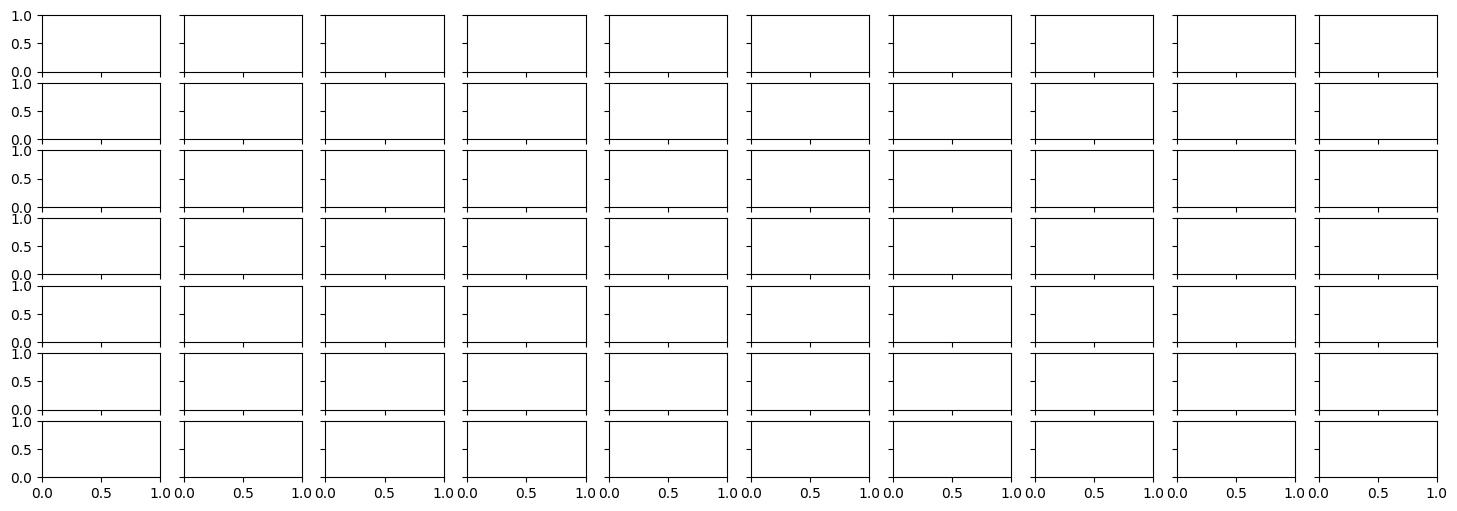

In [212]:
# Function to solve and return eigenvalues and eigenvectors
def solve_eigenvalues_and_vectors(L):
    eigenvalues, eigenvecs = eigh(L)  # Compute eigenvalues and eigenvectors
    return np.sqrt(np.abs(eigenvalues)), eigenvecs  # Return the square root of eigenvalues and eigenvectors

# Define sizes and shapes for the analysis
sizes = range(5, 36, 5)  # Grid sizes from 5x5 to 30x30 with steps of 5
shapes = ['square', 'rectangle', 'circle']
radius = 10  # Fixed radius for circular shape
results = {shape: [] for shape in shapes}

# Calculate eigenfrequencies and eigenvectors for each shape and size
for size in sizes:
    for shape in shapes:
        if shape == 'circle':
            L = create_circular_laplacian(size, size, radius=radius)
        else:
            L = create_reflective_laplacian(size, size if shape == 'square' else size * 2)  # Double the size for rectangle
        eigenvalues, eigenvecs = solve_eigenvalues_and_vectors(L)
        results[shape].append((eigenvalues[:10], eigenvecs[:, :10]))  # Store first 10 eigenfrequencies and corresponding eigenvectors

# Plotting the mode images
fig, axes = plt.subplots(len(sizes), 10, figsize=(18, 6), sharex=True, sharey=True)
for i, (size, shape_results) in enumerate(zip(sizes, square_results)):
    for j, (frequency, mode) in enumerate(zip(*shape_results)):
        mode_image = np.reshape(mode, (size, size))
        axes[i, j].imshow(mode_image, cmap='viridis', extent=[0, size, 0, size])
        axes[i, j].set_title(f'Mode {j+1}, Frequency: {frequency:.2f}')

plt.tight_layout()
plt.show()
